In [1]:
# # Display plots inline and change default figure size
# %matplotlib inline

# Package imports
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from pandas_datareader import data as datard
from datetime import datetime, timedelta
import yfinance
import matplotlib.ticker as mticker
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.signal import argrelextrema
from mplfinance.original_flavor import candlestick_ohlc


In [2]:
from statsmodels.nonparametric.kernel_regression import KernelReg

def find_local_extreme(data):
    df = data.copy()
    del df['High']
    del df['Low']
    del df['Open']
    prices = df.copy()
    prices = prices.reset_index()
    prices.columns = ['date', 'price']
    prices = prices['price']
    
    kr = KernelReg([prices.values], [prices.index.to_numpy()], var_type='c')
    f = kr.fit([prices.index])

    smooth_prices = pd.Series(data=f[0], index=df.index)

    # Use smoothed prices to determine local minima and maxima
    smooth_prices = pd.Series(data=f[0], index=prices.index)
    smooth_local_max = argrelextrema(smooth_prices.values, np.greater , order = 5)[0]
    smooth_local_min = argrelextrema(smooth_prices.values, np.less , order = 5)[0]
    local_max_min = np.sort(
        np.concatenate([smooth_local_max, smooth_local_min]))
    smooth_extrema = smooth_prices.loc[local_max_min]

    # Iterate over extrema arrays returning datetime of passed
    # prices array. Uses idxmax and idxmin to window for local extrema.
    price_local_max_dt = []
    for i in smooth_local_max:
        if (i > 1) and (i < len(prices)-1):
            price_local_max_dt.append(prices.iloc[i-2:i+2].idxmax())

    price_local_min_dt = []
    for i in smooth_local_min:
        if (i > 1) and (i < len(prices)-1):
            price_local_min_dt.append(prices.iloc[i-2:i+2].idxmin())

    maxima = pd.Series(prices.loc[price_local_max_dt])
    minima = pd.Series(prices.loc[price_local_min_dt])
    extrema = pd.concat([maxima, minima]).sort_index()

    # Return series for each with bar as index
    return extrema, prices, smooth_extrema, smooth_prices


In [3]:
from collections import defaultdict
def find_patterns(extrema, max_bars=35):
    """
    Input:
        extrema: extrema as pd.series with bar number as index
        max_bars: max bars for pattern to play out
    Returns:
        patterns: patterns as a defaultdict list of tuples
        containing the start and end bar of the pattern
    """
    patterns = defaultdict(list)

    # Need to start at five extrema for pattern generation
    for i in range(5, len(extrema)):
        window = extrema.iloc[i-5:i]

        # A pattern must play out within max_bars (default 35)
        if (window.index[-1] - window.index[0]) > max_bars:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1, e3, e5])
        rtop_g2 = np.mean([e2, e4])
        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):
            patterns['HS'].append((window.index[0], window.index[-1]))

        # Inverse Head and Shoulders
        elif (e1 < e2) and (e3 < e1) and (e3 < e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):
            patterns['IHS'].append((window.index[0], window.index[-1]))

        # Broadening Top
        elif (e1 > e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['BTOP'].append((window.index[0], window.index[-1]))

        # Broadening Bottom
        elif (e1 < e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['BBOT'].append((window.index[0], window.index[-1]))

        # Triangle Top
        elif (e1 > e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['TTOP'].append((window.index[0], window.index[-1]))

        # Triangle Bottom
        elif (e1 < e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['TBOT'].append((window.index[0], window.index[-1]))

        # Rectangle Top
        elif (e1 > e2) and \
                (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and \
                (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
                (min(e1, e3, e5) > max(e2, e4)):

            patterns['RTOP'].append((window.index[0], window.index[-1]))

        # Rectangle Bottom
        elif (e1 < e2) and \
                (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and \
                (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
                (max(e1, e3, e5) > min(e2, e4)):

            patterns['RBOT'].append((window.index[0], window.index[-1]))

    return patterns

In [4]:
def plot_window(prices, extrema, smooth_prices, smooth_extrema, ax=None):
    """
    Input: data from find_extrema
    Output: plots window for actual and smoothed prices and extrema
    """
    if ax is None:
        fig = plt.figure(figsize=[20,14])
        ax = fig.add_subplot(111)

    prices.plot(ax=ax, color='dodgerblue')
    ax.scatter(extrema.index, extrema.values, color='red')
    smooth_prices.plot(ax=ax, color='lightgrey')
    ax.scatter(smooth_extrema.index, smooth_extrema.values, color='lightgrey')

In [5]:
#plot_window(prices, extrema, smooth_prices, smooth_extrema)

In [6]:
# convert the price data in to actual candlestick parameters. Each candle has 4 parameters
# Open	High Low	Close -< conversion_array
# Size of the body measured by pips
# Size of the upper wicks measured by pips
# Size of the lower wicks measured by pips
# Type of the candle (Bullish or Bearish)(Green or Red)(0 or 1)


#Handle
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000, 4)
    candlestick_data[2]=round(round(wicks_down,5)*10000, 4)
    candlestick_data[3]=round(round(body_size,5)*10000, 4)

    return candlestick_data

In [7]:
def pre_processing(df):
    extrema, prices, smooth_extrema, smooth_prices = find_local_extreme(stock_df)
    patterns = find_patterns(extrema)
    cor_arr = []
    for name, pattern_periods in patterns.items():
        if name=='TTOP':    
            for start, end in pattern_periods:
                x = prices.index[start-1]
                y = prices.index[end+1]
                if (y-x < 40):
                    gap = 40 - y + x 
                    mid = int(gap / 2)
                    x = x - mid
                    y = y + gap - mid
                    cor_arr.append([x,y])
            
    X_raw_tmp = [] #Array for actual data
    X_tmp = [] #Array for converted data
    Y_tmp = [] #Array for prediction based on the condition whether the mean close value of next two week is higher than current close value

    for row in cor_arr:
        tmp = []
        mean = []
        prediction = 0
        X_raw_tmp.append(df.values[row[0] : row[1]]) # append raw value

        for idx in range(row[0] , row[1]):
            converted_data = ohlc_to_candlestick(df.values[idx])
            tmp.append(converted_data) # convert data to cds 

        for idx in range(row[1], row[1] + 14):
            mean.append(df.values[idx][3])

        X_tmp.append(tmp)
        if (np.mean(mean) > df.values[row[1]][3]):
            prediction = 1
        Y_tmp.append(prediction)

    X_tmp = np.asarray(X_tmp)
    X_raw_tmp = np.asarray(X_raw_tmp)
    Y_tmp = np.asarray(Y_tmp)

    return X_tmp, Y_tmp, X_raw_tmp

X  = np.empty((0, 40 ,4))
Y = np.empty((0))
X_raw = np.empty((0, 40 ,4))


In [8]:
X  = np.empty((0, 40 ,4))
Y = np.empty((0))
X_raw = np.empty((0, 40 ,4))

In [9]:
stocks = ['AAPL' , 'MSFT' , 'AMD' , 'FB' , 'AMD' , 'FB' , 'AMZN']
# , , 'ADSK' , 'ANSS' ,  'AVGO' , 'AZN' , 'FISV' , 'GILD' , 'KHC' , 'NFLX' , 'OKTA' , 'REGN
endDate = pd.to_datetime('today')
startDate = endDate - timedelta(days = 300  * 30)

for stock in stocks:
  stock_df = yfinance.download(stock , startDate , endDate  )
  del stock_df['Volume']
  del stock_df['Adj Close']
  X1 , Y1 , X_raw1 = pre_processing(stock_df)
  X = np.concatenate((X, X1) , axis= 0)
  Y = np.concatenate((Y, Y1) , axis= 0)
  X_raw = np.concatenate((X_raw, X_raw1) , axis= 0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
X.shape

(119, 40, 4)

In [11]:
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(layers.LSTM(units = 25,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(layers.LSTM(units = 50))
model.add(Dropout(0.1))
model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [12]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5 , shuffle = False)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5 , shuffle = False)
X_train_raw, X_val_and_test_raw = train_test_split(X_raw, test_size=0.5 , shuffle = False )
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.5 , shuffle = False)


In [13]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Set up early stop
early_stopping = keras.callbacks.EarlyStopping(patience=20)

In [14]:
history = model.fit(X_train, Y_train, epochs= 500 , validation_data=(X_val, Y_val) , callbacks=[model_checkpoint , early_stopping])

Epoch 1/500
1/2 [==============>...............] - ETA: 4s - loss: 0.6623 - acc: 0.6250

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 12s 8s/step - loss: 0.6800 - acc: 0.5932 - val_loss: 0.6713 - val_acc: 0.6000
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6759 - acc: 0.5938

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.6821 - acc: 0.5932 - val_loss: 0.6673 - val_acc: 0.6000
Epoch 3/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6729 - acc: 0.5938

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.6589 - acc: 0.6271 - val_loss: 0.6644 - val_acc: 0.6000
Epoch 4/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6560 - acc: 0.5625

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.6592 - acc: 0.5932 - val_loss: 0.6637 - val_acc: 0.6000
Epoch 5/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6290 - acc: 0.6562

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.6698 - acc: 0.5932 - val_loss: 0.6613 - val_acc: 0.6333
Epoch 6/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6770 - acc: 0.5625

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.6653 - acc: 0.6271 - val_loss: 0.6595 - val_acc: 0.6333
Epoch 7/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6953 - acc: 0.5312

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.6576 - acc: 0.6271 - val_loss: 0.6585 - val_acc: 0.6333
Epoch 8/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6620 - acc: 0.5938

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 6s 6s/step - loss: 0.6424 - acc: 0.6102 - val_loss: 0.6550 - val_acc: 0.6333
Epoch 9/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6513 - acc: 0.6250

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.6532 - acc: 0.6271 - val_loss: 0.6514 - val_acc: 0.6333
Epoch 10/500
2/2 [==============================] - 0s 45ms/step - loss: 0.6329 - acc: 0.6102 - val_loss: 0.6524 - val_acc: 0.6333
Epoch 11/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6512 - acc: 0.6875

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.6355 - acc: 0.6610 - val_loss: 0.6493 - val_acc: 0.6667
Epoch 12/500
1/2 [==============>...............] - ETA: 0s - loss: 0.5901 - acc: 0.6875

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 6s 6s/step - loss: 0.6175 - acc: 0.6441 - val_loss: 0.6431 - val_acc: 0.6667
Epoch 13/500
2/2 [==============================] - 0s 45ms/step - loss: 0.6154 - acc: 0.6441 - val_loss: 0.6522 - val_acc: 0.6333
Epoch 14/500
2/2 [==============================] - 0s 44ms/step - loss: 0.5896 - acc: 0.6780 - val_loss: 0.6533 - val_acc: 0.6667
Epoch 15/500
1/2 [==============>...............] - ETA: 0s - loss: 0.5943 - acc: 0.7812

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.6513 - acc: 0.6610 - val_loss: 0.6403 - val_acc: 0.6000
Epoch 16/500
1/2 [==============>...............] - ETA: 0s - loss: 0.5913 - acc: 0.7500

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 6s 6s/step - loss: 0.5967 - acc: 0.7458 - val_loss: 0.6379 - val_acc: 0.6667
Epoch 17/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6033 - acc: 0.6250

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.5883 - acc: 0.6610 - val_loss: 0.6194 - val_acc: 0.6667
Epoch 18/500
1/2 [==============>...............] - ETA: 0s - loss: 0.5562 - acc: 0.6875

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 6s 6s/step - loss: 0.5641 - acc: 0.6610 - val_loss: 0.6177 - val_acc: 0.6667
Epoch 19/500
2/2 [==============================] - 0s 50ms/step - loss: 0.5887 - acc: 0.6610 - val_loss: 0.6302 - val_acc: 0.7000
Epoch 20/500
1/2 [==============>...............] - ETA: 0s - loss: 0.5483 - acc: 0.8750

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 6s 6s/step - loss: 0.5516 - acc: 0.7966 - val_loss: 0.6057 - val_acc: 0.6000
Epoch 21/500
2/2 [==============================] - 0s 48ms/step - loss: 0.5008 - acc: 0.7458 - val_loss: 0.6309 - val_acc: 0.6667
Epoch 22/500
2/2 [==============================] - 0s 44ms/step - loss: 0.5332 - acc: 0.7458 - val_loss: 0.6123 - val_acc: 0.6667
Epoch 23/500
1/2 [==============>...............] - ETA: 0s - loss: 0.5592 - acc: 0.7812

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 6s 6s/step - loss: 0.5410 - acc: 0.7288 - val_loss: 0.6056 - val_acc: 0.6667
Epoch 24/500
1/2 [==============>...............] - ETA: 0s - loss: 0.4683 - acc: 0.8750

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.5311 - acc: 0.7797 - val_loss: 0.6047 - val_acc: 0.6667
Epoch 25/500
2/2 [==============================] - 0s 49ms/step - loss: 0.5078 - acc: 0.7119 - val_loss: 0.6067 - val_acc: 0.7000
Epoch 26/500
1/2 [==============>...............] - ETA: 0s - loss: 0.4159 - acc: 0.8750

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.4635 - acc: 0.8136 - val_loss: 0.5961 - val_acc: 0.7333
Epoch 27/500
2/2 [==============================] - 0s 72ms/step - loss: 0.4305 - acc: 0.8983 - val_loss: 0.6323 - val_acc: 0.7333
Epoch 28/500
2/2 [==============================] - 0s 59ms/step - loss: 0.4160 - acc: 0.8475 - val_loss: 0.6768 - val_acc: 0.5667
Epoch 29/500
1/2 [==============>...............] - ETA: 0s - loss: 0.6201 - acc: 0.5625

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.6294 - acc: 0.5424 - val_loss: 0.5611 - val_acc: 0.7000
Epoch 30/500
1/2 [==============>...............] - ETA: 0s - loss: 0.4240 - acc: 0.9062

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.4515 - acc: 0.8814 - val_loss: 0.5550 - val_acc: 0.7333
Epoch 31/500
1/2 [==============>...............] - ETA: 0s - loss: 0.3173 - acc: 0.9688

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 8s 8s/step - loss: 0.3993 - acc: 0.8983 - val_loss: 0.5434 - val_acc: 0.7333
Epoch 32/500
2/2 [==============================] - 0s 53ms/step - loss: 0.3951 - acc: 0.8644 - val_loss: 0.6542 - val_acc: 0.7000
Epoch 33/500
2/2 [==============================] - 0s 55ms/step - loss: 0.3894 - acc: 0.8475 - val_loss: 0.6017 - val_acc: 0.6667
Epoch 34/500
2/2 [==============================] - 0s 57ms/step - loss: 0.4134 - acc: 0.8136 - val_loss: 0.5665 - val_acc: 0.6333
Epoch 35/500
2/2 [==============================] - 0s 187ms/step - loss: 0.3556 - acc: 0.8644 - val_loss: 0.5649 - val_acc: 0.7333
Epoch 36/500
1/2 [==============>...............] - ETA: 0s - loss: 0.2759 - acc: 0.9375

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 6s 6s/step - loss: 0.3313 - acc: 0.8983 - val_loss: 0.5367 - val_acc: 0.7333
Epoch 37/500
2/2 [==============================] - 0s 49ms/step - loss: 0.3727 - acc: 0.8305 - val_loss: 0.7381 - val_acc: 0.5000
Epoch 38/500
2/2 [==============================] - 0s 48ms/step - loss: 0.4525 - acc: 0.7119 - val_loss: 0.5932 - val_acc: 0.7000
Epoch 39/500
2/2 [==============================] - 0s 53ms/step - loss: 0.3477 - acc: 0.9322 - val_loss: 0.5581 - val_acc: 0.7000
Epoch 40/500
2/2 [==============================] - 0s 46ms/step - loss: 0.3078 - acc: 0.8983 - val_loss: 0.5550 - val_acc: 0.7333
Epoch 41/500
2/2 [==============================] - 0s 48ms/step - loss: 0.3149 - acc: 0.9153 - val_loss: 0.5610 - val_acc: 0.7000
Epoch 42/500
2/2 [==============================] - 0s 48ms/step - loss: 0.2842 - acc: 0.8983 - val_loss: 0.5824 - val_acc: 0.7333
Epoch 43/500
2/2 [==============================] - 0s 46ms/step - loss: 0.2628 - acc: 0.9153 - va

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 7s 7s/step - loss: 0.2325 - acc: 0.9153 - val_loss: 0.5277 - val_acc: 0.7667
Epoch 47/500
2/2 [==============================] - 0s 211ms/step - loss: 0.2069 - acc: 0.9492 - val_loss: 0.6316 - val_acc: 0.7333
Epoch 48/500
2/2 [==============================] - 0s 60ms/step - loss: 0.2410 - acc: 0.8814 - val_loss: 0.5419 - val_acc: 0.7333
Epoch 49/500
2/2 [==============================] - 0s 50ms/step - loss: 0.3923 - acc: 0.8305 - val_loss: 0.5565 - val_acc: 0.7333
Epoch 50/500
2/2 [==============================] - 0s 47ms/step - loss: 0.2363 - acc: 0.9492 - val_loss: 0.5341 - val_acc: 0.8000
Epoch 51/500
2/2 [==============================] - 0s 51ms/step - loss: 0.2017 - acc: 0.9661 - val_loss: 0.5457 - val_acc: 0.8000
Epoch 52/500
2/2 [==============================] - 0s 50ms/step - loss: 0.1846 - acc: 0.9661 - val_loss: 0.6528 - val_acc: 0.7000
Epoch 53/500
1/2 [==============>...............] - ETA: 0s - loss: 0.2323 - acc: 0.8438

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


2/2 [==============================] - 6s 6s/step - loss: 0.2823 - acc: 0.8644 - val_loss: 0.4858 - val_acc: 0.7667
Epoch 54/500
2/2 [==============================] - 0s 56ms/step - loss: 0.1687 - acc: 0.9492 - val_loss: 0.5111 - val_acc: 0.7333
Epoch 55/500
2/2 [==============================] - 0s 60ms/step - loss: 0.1472 - acc: 0.9661 - val_loss: 0.5018 - val_acc: 0.8000
Epoch 56/500
2/2 [==============================] - 0s 59ms/step - loss: 0.1283 - acc: 0.9831 - val_loss: 0.5246 - val_acc: 0.8000
Epoch 57/500
2/2 [==============================] - 0s 54ms/step - loss: 0.1453 - acc: 0.9661 - val_loss: 0.6092 - val_acc: 0.7667
Epoch 58/500
2/2 [==============================] - 0s 54ms/step - loss: 0.2168 - acc: 0.9492 - val_loss: 0.5172 - val_acc: 0.8000
Epoch 59/500
2/2 [==============================] - 0s 49ms/step - loss: 0.1353 - acc: 0.9492 - val_loss: 0.5133 - val_acc: 0.7667
Epoch 60/500
2/2 [==============================] - 0s 47ms/step - loss: 0.1635 - acc: 0.9492 - va

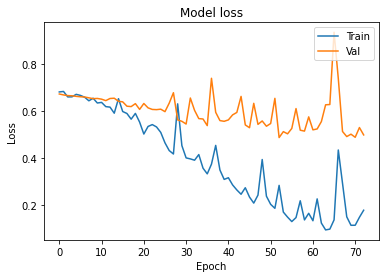

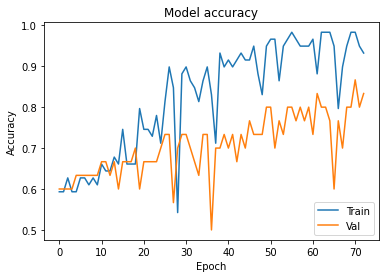

In [15]:
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

1/1 [==============================] - 0s 25ms/step - loss: 1.2324 - acc: 0.5333
Test accuracy: 0.5333333611488342


In [17]:
# Timestep = List of candles seqeuence
# Items = Candlestick
# Features = High, Low, Open, Close parametes
def graph_data_ohlc(dataset):
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date = range(len(closep))

    x = 0
    y = len(date)
    ohlc = []

    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x += 1

    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
        
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)


    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)    
    plt.show()

[0.8937496]
Correct trend is Bullish
Model prediction trend is Bullish
WON


C:\Python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


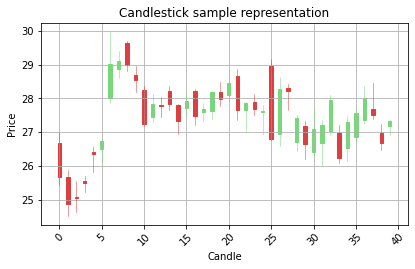

[0.964298]
Correct trend is Bullish
Model prediction trend is Bullish
WON


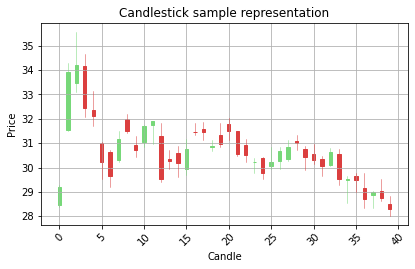

[0.98661804]
Correct trend is Bullish
Model prediction trend is Bullish
WON


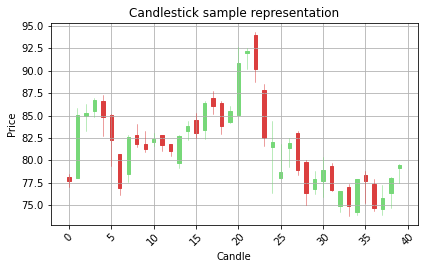

[0.15065056]
Correct trend is Bearish
Model prediction trend is Bearish
WON


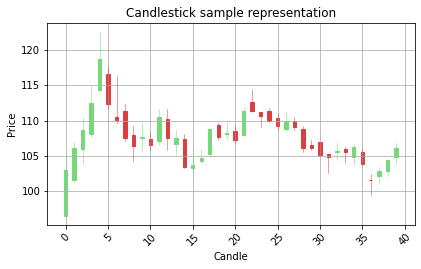

[0.9670082]
Correct trend is Bullish
Model prediction trend is Bullish
WON


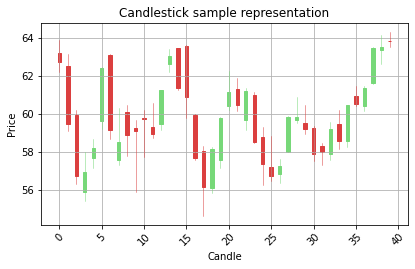

[0.5611196]
Correct trend is Bullish
Model prediction trend is Bullish
WON


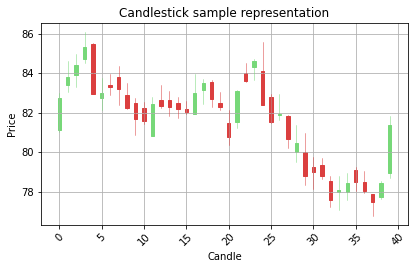

[0.08601487]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


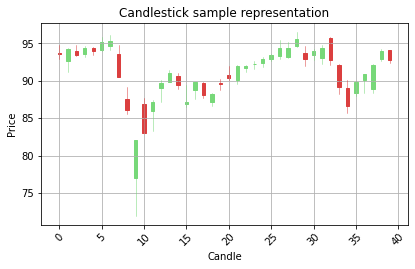

[0.97869647]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


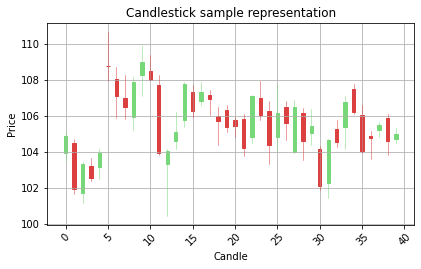

[0.982766]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


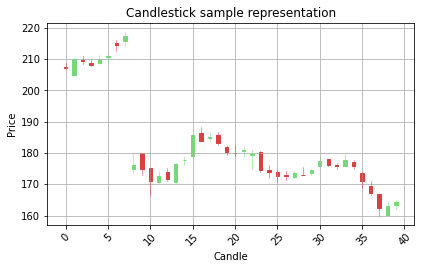

[0.34042022]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


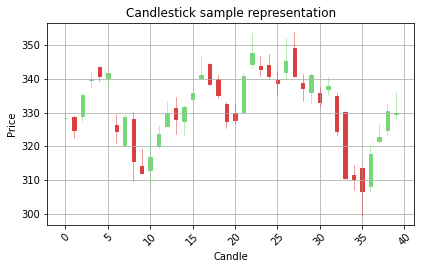

[0.98709923]
Correct trend is Bullish
Model prediction trend is Bullish
WON


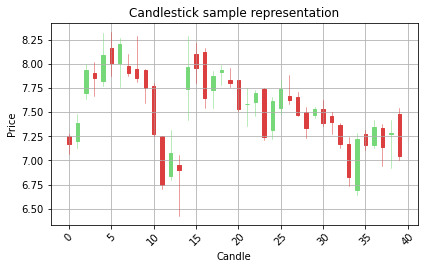

[0.963925]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


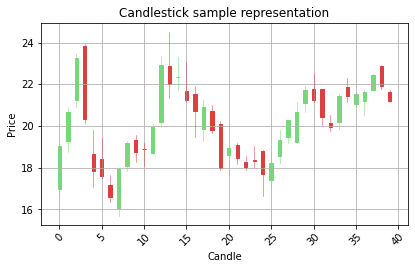

[0.6898976]
Correct trend is Bullish
Model prediction trend is Bullish
WON


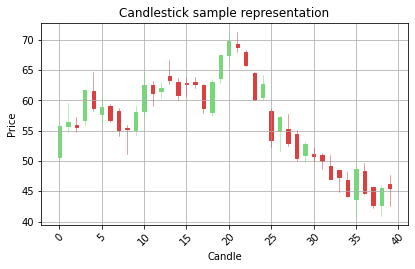

[0.621126]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


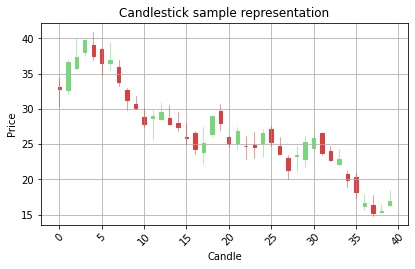

[0.97401667]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


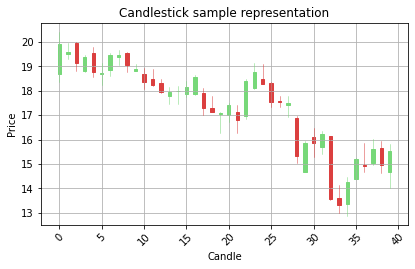

[0.10609764]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


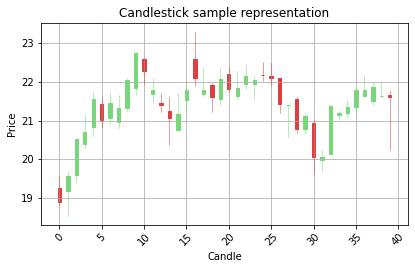

[0.09835273]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


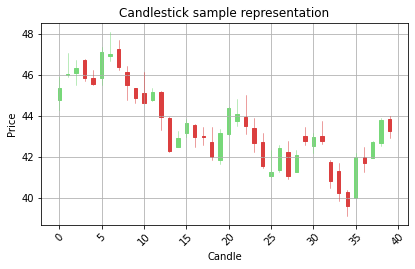

[0.9292238]
Correct trend is Bullish
Model prediction trend is Bullish
WON


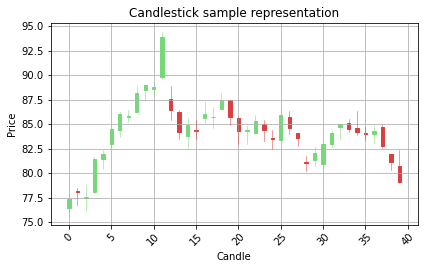

[0.9708619]
Correct trend is Bullish
Model prediction trend is Bullish
WON


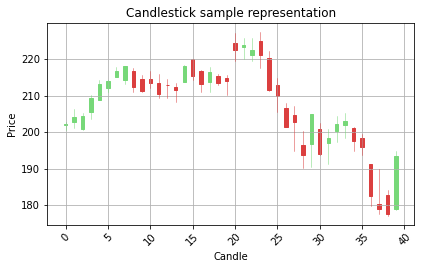

[0.978564]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


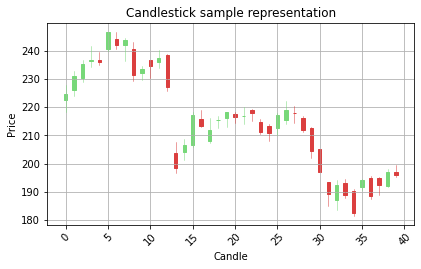

[0.73526573]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


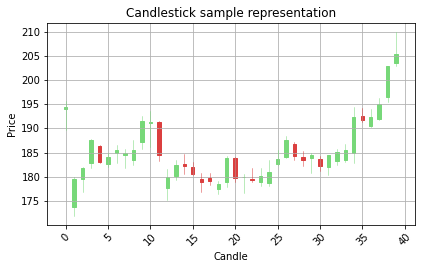

[0.2095756]
Correct trend is Bearish
Model prediction trend is Bearish
WON


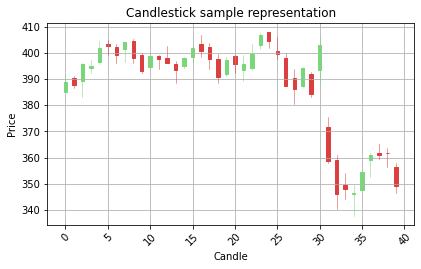

[0.93320847]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


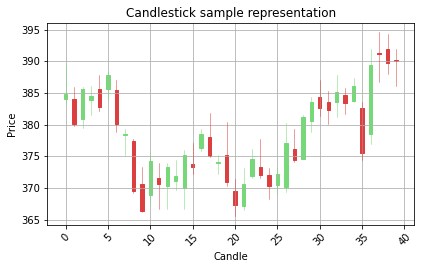

[0.30768695]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


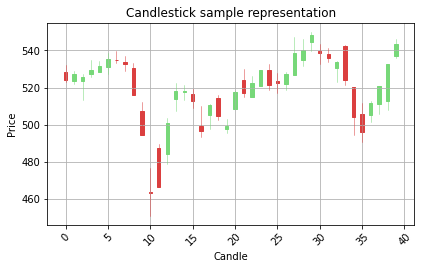

[0.88969135]
Correct trend is Bullish
Model prediction trend is Bullish
WON


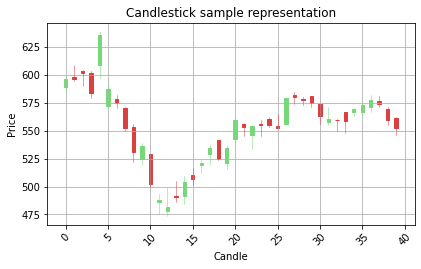

[0.98854256]
Correct trend is Bullish
Model prediction trend is Bullish
WON


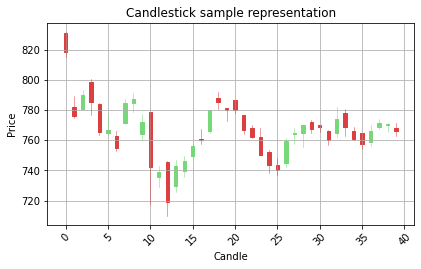

[0.82127213]
Correct trend is Bullish
Model prediction trend is Bullish
WON


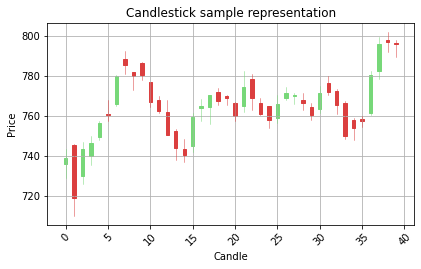

[0.84482163]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


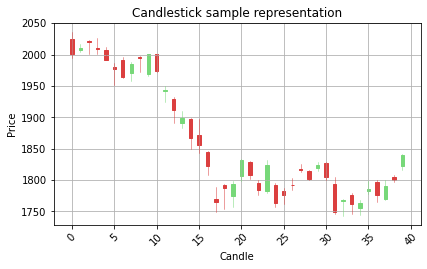

[0.9027195]
Correct trend is Bullish
Model prediction trend is Bullish
WON


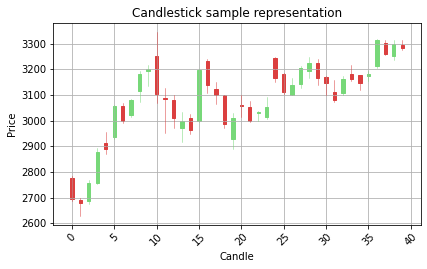

[0.9807633]
Correct trend is Bullish
Model prediction trend is Bullish
WON


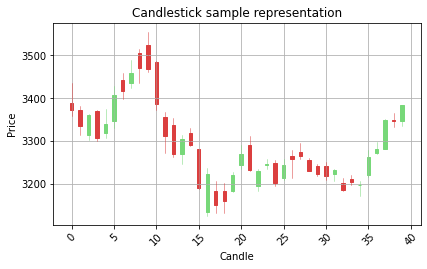

Won: 16 Lost: 14
Success rate: 53.33%


In [18]:

counter = 0
won = 0
lost = 0
bullish_counter = 0
bearish_counter = 0
test = model.predict(X_test)
alpha_distance = 0.5

for a in test:
    print(a)
    if a > (1-alpha_distance) or a < alpha_distance :
        if Y_test[counter] == 1:
            print('Correct trend is Bullish')
            bullish_counter = bullish_counter + 1
        if Y_test[counter] == 0:
            print('Correct trend is Bearish')
            bearish_counter = bearish_counter + 1
        if a > (1-alpha_distance):print('Model prediction trend is Bullish')
        if a < alpha_distance:print('Model prediction trend is Bearish')

        if (a > (1-alpha_distance) and Y_test[counter] == 1) or (a < alpha_distance and Y_test[counter] == 0):
            won=won+1
            print('WON')
        else:
            print('LOST')
            lost=lost+1

        d_arr = np.empty(( 0 ,4))

        d_arr = np.append(d_arr , X_test_raw[counter] , axis= 0 )
        

        graph_data_ohlc(d_arr)

    counter=counter+1
    
print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')


In [19]:
bearish_counter / ( bullish_counter + bearish_counter)

0.36666666666666664